In [1]:
!pip install evaluate

In [2]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import numpy as np
import evaluate
import torch
from datasets import load_dataset, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [3]:
# load model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [4]:
# load dataset
ds = load_dataset("dalopeza98/isear-cleaned-dataset")

In [5]:
num_to_emotion = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]

In [6]:
# example listing of text and corresponding label
n = 74
text = ds["train"][n]["text"]
label = num_to_emotion[ds["train"][n]["label"]]
print(text)
print()
print(label)

I was drinking a glass of wine and eating something when there á
suddenly appeared pictures about the famine in some parts of á
Africa

shame


In [7]:
def tokenize_function(examples):
    # tokenize and pad/truncate length
    tokenized_inputs = tokenizer(examples["text"], padding="max_length", truncation=True, max_length=256)

    return tokenized_inputs

# tokenize training and testing data
tokenized_train = ds["train"].map(tokenize_function)
tokenized_test = ds["test"].map(tokenize_function)

In [8]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 6027
})

In [9]:
training_args = TrainingArguments(
    output_dir="test_trainer",
    eval_strategy="epoch",
    report_to="none",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    logging_steps=500,
    gradient_accumulation_steps=1,
    num_train_epochs=3
)

In [10]:
metric = evaluate.load("accuracy")

In [11]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [12]:
# trainer will store the fine-tuned model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics,
)

In [13]:
eval_dataloader = trainer.get_eval_dataloader()
for batch in eval_dataloader:
    print(f"Batch size: {len(batch)}")  # Print the batch size of each batch
    break  # Only check the first batch

Batch size: 4


In [14]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,1.022200,0.944477,0.684804
2,0.694800,1.095087,0.708029
3,0.341100,1.461694,0.712011


TrainOutput(global_step=4521, training_loss=0.7203743246323607, metrics={'train_runtime': 1174.3829, 'train_samples_per_second': 15.396, 'train_steps_per_second': 3.85, 'total_flos': 2378762280921600.0, 'train_loss': 0.7203743246323607, 'epoch': 3.0})

In [15]:
trainer.evaluate()

{'eval_loss': 1.4616940021514893,
 'eval_accuracy': 0.7120106171201062,
 'eval_runtime': 23.7609,
 'eval_samples_per_second': 63.423,
 'eval_steps_per_second': 15.866,
 'epoch': 3.0}

In [16]:
# confirm number of labels is 7
model_config = trainer.model.config
print(f"Number of labels: {model_config.num_labels}")

Number of labels: 7


In [17]:
def pred_sample_from_index(index):

  device = trainer.model.device  # ensure operations are being made on same device (should be GPU)

  single_sample = tokenized_test[index]

  # configured input as dictionary of tensors (expected by trainer)
  inputs = {
      'input_ids': torch.tensor(single_sample['input_ids']).unsqueeze(0).to(device),
      'attention_mask': torch.tensor(single_sample['attention_mask']).unsqueeze(0).to(device),
  }

  if 'token_type_ids' in single_sample:
      inputs['token_type_ids'] = torch.tensor(single_sample['token_type_ids']).unsqueeze(0).to(device)

  with torch.no_grad():
      logits = trainer.model(**inputs).logits

  # convert logits to predicted class (the class with the highest logit)
  predictions = np.argmax(logits.cpu().numpy(), axis=-1)

  # store predicted class
  predicted_class = predictions[0]
  return predicted_class


In [18]:
y_pred = []
for i in range(len(tokenized_test)):
  y_pred.append(pred_sample_from_index(i))

In [19]:
y_test = ds["test"]["label"]

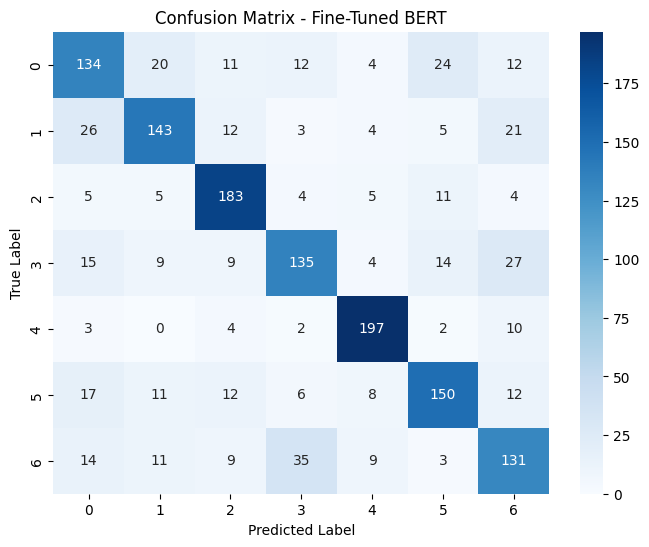

Accuracy: 71.20%


In [20]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title('Confusion Matrix - Fine-Tuned BERT')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

accuracy = accuracy_score(y_test, y_pred)

print(f"Accuracy: {accuracy * 100:.2f}%")

In [21]:
print("Classification Report for Fine-Tuned BERT Model:")
print(classification_report(y_test, y_pred))

Classification Report for Fine-Tuned BERT Model:
              precision    recall  f1-score   support

           0       0.63      0.62      0.62       217
           1       0.72      0.67      0.69       214
           2       0.76      0.84      0.80       217
           3       0.69      0.63      0.66       213
           4       0.85      0.90      0.88       218
           5       0.72      0.69      0.71       216
           6       0.60      0.62      0.61       212

    accuracy                           0.71      1507
   macro avg       0.71      0.71      0.71      1507
weighted avg       0.71      0.71      0.71      1507



In [22]:
#print(f"Text: {single_sample['text']}")
#print(f"Predicted class for the single sample: {num_to_emotion[predicted_class]}")